<a href="https://colab.research.google.com/github/Nas-Z/Nas-Z-Movie-Genre-Predictor_ML/blob/main/predict_movie_genre_by_poster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt

In [3]:
os.environ['KAGGLEHUB_CACHE'] = '/content/data'

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("neha1703/movie-genre-from-its-poster")

print("Path to dataset files:", path)

100%|██████████| 35.9M/35.9M [00:00<00:00, 95.6MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/neha1703/movie-genre-from-its-poster/versions/5


##Load the CSV file wich contains genre for each movie

In [2]:
#Load the genres data
df = pd.read_csv('/content/data/datasets/neha1703/movie-genre-from-its-poster/versions/5/MovieGenre.csv', encoding='latin-1')

In [3]:
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40108 entries, 0 to 40107
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   imdbId      40108 non-null  int64  
 1   Imdb Link   40108 non-null  object 
 2   Title       40108 non-null  object 
 3   IMDB Score  40060 non-null  float64
 4   Genre       39963 non-null  object 
 5   Poster      39383 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.8+ MB


##Preprocess the genres data

In [5]:
#make every movie speicified with only its first genre
df['Genre']= df['Genre'].str.split('|').str[0]

In [6]:
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy,https://images-na.ssl-images-amazon.com/images...


In [7]:
#Extract the genre for each poster
ground_truth = []
for file in sorted(os.listdir('Posters')):
    image_id = int(file.split('.')[0])
    genre = df.loc[df['imdbId'] == image_id, 'Genre'].values[0]
    ground_truth.append(genre)

In [8]:
le = LabelEncoder()
ground_truth = le.fit_transform(ground_truth)

genres = {
    0: 'Action',
    1: 'Adventure',
    2: 'Animation',
    3: 'Biography',
    4: 'Comedy',
    5: 'Crime',
    6: 'Documentary',
    7: 'Drama',
    8: 'Family',
    9: 'Fantasy',
    10: 'History',
    11: 'Horror',
    12: 'Music',
    13: 'Musical',
    14: 'Mystery',
    15: 'Romance',
    16: 'Short',
    17: 'War',
    18: 'Western'
}

##Preprocess the posters images

In [10]:
image_size = (224, 224)
all_images = []

for file in sorted(os.listdir("Posters")):
    image_path = os.path.join("Posters", file)

    image = Image.open(image_path).convert("RGB")
    image = image.resize(image_size)

    all_images.append(image)

all_images = np.array(all_images)
print("all_images shape:", all_images.shape)


all_images shape: (997, 224, 224, 3)


##Define the Model

In [ ]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = models.resnet18(pretrained=True)
for p in model.parameters():
    p.requires_grad = False
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(set(ground_truth))) #Which is 19 genre class

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

##Implement Dataset Class

In [14]:
class MoviePosterDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.labels = labels
        self.imgs = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        image = self.transform(image)
        label = self.labels[idx]

        return image, label


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    all_images, ground_truth, test_size=0.2, random_state=42
)

# Create datasets
train_dataset = MoviePosterDataset( X_train, y_train,transform)
test_dataset = MoviePosterDataset( X_test, y_test, transform)
## transform is different than
#data leak!!!

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#batch size vs accuracy


##Train the Model

In [17]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001) ##Adam vs AdamW, weight_decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2)

In [18]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        ##gradient clipping
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 2.9002
Epoch 2/10, Loss: 2.1001
Epoch 3/10, Loss: 2.0388
Epoch 4/10, Loss: 2.0487
Epoch 5/10, Loss: 2.0561
Epoch 6/10, Loss: 2.0293
Epoch 7/10, Loss: 1.9959
Epoch 8/10, Loss: 1.8572
Epoch 9/10, Loss: 1.9506
Epoch 10/10, Loss: 1.9593


In [19]:
for p in model.parameters():
    p.requires_grad = True

In [20]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        ##gradient clipping
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 1.8520
Epoch 2/10, Loss: 1.5566
Epoch 3/10, Loss: 0.8253
Epoch 4/10, Loss: 0.3843
Epoch 5/10, Loss: 0.2162
Epoch 6/10, Loss: 0.1691
Epoch 7/10, Loss: 0.0818
Epoch 8/10, Loss: 0.0674
Epoch 9/10, Loss: 0.0302
Epoch 10/10, Loss: 0.0486


##Test the model with external images

In [32]:
image_paths = ["0x0.webp", "mu.webp", "laland.jpg"]
images = []
image_tensors = []

for path in image_paths:
    img = Image.open(path).convert("RGB")
    img_transformed = transform(img)
    image_tensors.append(img_transformed.unsqueeze(0))
    images.append(img)


In [33]:
model.eval()

image_batch = torch.cat(image_tensors).to(device)

with torch.no_grad():
    outputs = model(image_batch)
    predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy()

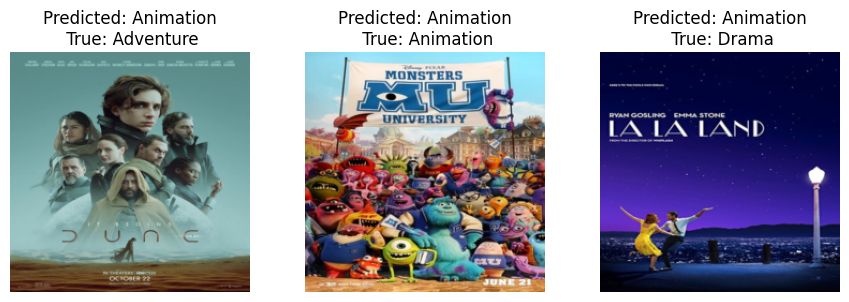

In [36]:
def denormalize(image):
    image = image.cpu().numpy().transpose(1, 2, 0)
    image = image * std + mean
    return image.clip(0, 1)


mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

cols = 3
rows = (len(images) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

true_labels = ['Adventure', 'Animation', 'Drama']

for i, (img_tensor, ax) in enumerate(zip(image_tensors, axes)):
    img_np = denormalize(img_tensor.squeeze(0))
    ax.imshow(img_np)
    ax.set_title(f"Predicted: {genres[predicted_classes[i]]}\n True: {true_labels[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()